# Sinkhorn OT Resampling: Bias–Variance–Speed Trade-off

## Range-Bearing Tracking Model

Uses the range-bearing SSM from our codebase:

**State:** $\mathbf{x}_t = [p_x, p_y, v_x, v_y]^T \in \mathbb{R}^4$

**Transition (constant velocity):**
$$\mathbf{x}_t = F\,\mathbf{x}_{t-1} + \mathbf{v}_t, \quad \mathbf{v}_t \sim \mathcal{N}(0, Q)$$

**Observation (range-bearing with Student-t noise, $\nu=2$):**
$$\mathbf{z}_t = \begin{bmatrix} \sqrt{p_x^2 + p_y^2} \\ \text{atan2}(p_y,\, p_x) \end{bmatrix} + \mathbf{w}_t, \quad \mathbf{w}_t \sim t_\nu(0, \text{diag}(\sigma_r^2, \sigma_\theta^2))$$

This is hard for PFs because:
- Nonlinear observation → multi-modal likelihood in Cartesian space
- Student-t noise ($\nu=2$) → heavy tails, occasional outliers, sharp weight peaks
- 4D state → particles spread, quality resampling matters

We measure per (ε, K): **mean RMSE** (bias), **std RMSE** (variance), **mean time** (speed).

In [1]:
!pip install -q tensorflow-probability

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time

tfd = tfp.distributions

print(f"TF: {tf.__version__}, TFP: {tfp.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TF: 2.19.0, TFP: 0.25.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Utilities

In [2]:
def normalize_log_weights(log_w):
    log_sum = tf.math.reduce_logsumexp(log_w, axis=-1, keepdims=True)
    return log_w - log_sum, tf.squeeze(log_sum, axis=-1)

def effective_sample_size(log_w_norm):
    return tf.exp(-tf.math.reduce_logsumexp(2.0 * log_w_norm, axis=-1))

## Sinkhorn Resampler

In [3]:
class SinkhornResampler:
    def __init__(self, epsilon=0.5, num_iters=50):
        self.epsilon = epsilon
        self.num_iters = num_iters

    def _cost_matrix(self, particles):
        diff = particles[:, :, None, :] - particles[:, None, :, :]
        return tf.reduce_sum(diff ** 2, axis=-1)

    def _sinkhorn(self, C, log_a):
        N = tf.shape(C)[1]
        Nf = tf.cast(N, tf.float32)
        log_b = -tf.math.log(Nf) * tf.ones_like(log_a)
        log_K = -C / self.epsilon

        log_u = tf.zeros_like(log_a)
        log_v = tf.zeros_like(log_b)

        for _ in range(self.num_iters):
            log_u = log_a - tf.math.reduce_logsumexp(
                log_K + log_v[:, None, :], axis=-1)
            log_v = log_b - tf.math.reduce_logsumexp(
                log_K + log_u[:, :, None], axis=1)

        log_T = log_u[:, :, None] + log_K + log_v[:, None, :]
        return tf.exp(log_T)

    def __call__(self, particles, log_w_norm):
        N = tf.shape(particles)[1]
        Nf = tf.cast(N, tf.float32)
        C = self._cost_matrix(particles)
        T = self._sinkhorn(C, log_w_norm)
        transform = Nf * tf.transpose(T, perm=[0, 2, 1])
        resampled = tf.matmul(transform, particles)
        new_log_w = -tf.math.log(Nf) * tf.ones(
            [tf.shape(particles)[0], N], dtype=tf.float32)
        return resampled, new_log_w

## Range-Bearing SSM (TF port of `range_bearing.py`)

Adapted from our NumPy/SciPy implementation to TensorFlow.

In [4]:
class RangeBearingTransition:
    """Constant-velocity transition: x_t = F @ x_{t-1} + N(0, Q).

    State: [px, py, vx, vy]
    Following range_bearing.py: dt=0.01, q_diag=0.01
    """

    def __init__(self, dt=0.01, q_diag=0.01):
        self.F = tf.constant([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1,  0],
            [0, 0, 0,  1],
        ], dtype=tf.float32)

        Q_np = np.diag(np.full(4, q_diag)).astype(np.float32)
        self.Q_chol = tf.constant(np.linalg.cholesky(
            Q_np + 1e-6 * np.eye(4)), dtype=tf.float32)

    def sample(self, particles):
        """Propagate [B, N, 4] particles."""
        mean = tf.linalg.matvec(self.F, particles)  # broadcasts
        noise = tfd.MultivariateNormalTriL(
            loc=tf.zeros(4), scale_tril=self.Q_chol
        ).sample(tf.shape(particles)[:2])
        return mean + noise


class RangeBearingObservation:
    """Range-bearing observation with Student-t noise.

    z = [sqrt(px^2 + py^2), atan2(py, px)] + t_nu(0, diag(s_r^2, s_th^2))

    Following range_bearing.py: nu=2, s_r=0.01, s_th=0.01
    """

    def __init__(self, nu=2.0, s_r=0.01, s_th=0.01):
        self.nu = nu
        self.s_r = s_r
        self.s_th = s_th

    def _h(self, particles):
        """Observation function. particles: [B, N, 4] -> [B, N, 2]."""
        px = particles[..., 0]
        py = particles[..., 1]
        r = tf.sqrt(px**2 + py**2 + 1e-12)
        th = tf.math.atan2(py, px)
        return tf.stack([r, th], axis=-1)

    @staticmethod
    def _wrap_angle(a):
        return (a + np.pi) % (2.0 * np.pi) - np.pi

    def log_prob(self, y_t, particles):
        """Student-t log-likelihood.

        Args:
            y_t: [2] observation [range, bearing]
            particles: [B, N, 4]
        Returns:
            log_lik: [B, N]
        """
        y_pred = self._h(particles)  # [B, N, 2]

        # Range residual
        res_r = y_t[0] - y_pred[..., 0]        # [B, N]

        # Bearing residual (wrapped)
        res_th = self._wrap_angle(y_t[1] - y_pred[..., 1])  # [B, N]

        # Student-t log-pdf: tfd.StudentT
        dist_r = tfd.StudentT(df=self.nu, loc=0.0, scale=self.s_r)
        dist_th = tfd.StudentT(df=self.nu, loc=0.0, scale=self.s_th)

        return dist_r.log_prob(res_r) + dist_th.log_prob(res_th)


print("RangeBearingTransition & RangeBearingObservation defined.")

RangeBearingTransition & RangeBearingObservation defined.


## Particle Filter Loop

In [5]:
class DifferentiableParticleFilter:
    def __init__(self, transition, observation, resampler,
                 ess_threshold=0.5):
        self.transition = transition
        self.observation = observation
        self.resampler = resampler
        self.ess_threshold = ess_threshold

    def filter(self, observations, batch_size=1, n_particles=100,
               initial_particles=None):
        T_len = observations.shape[0]

        if initial_particles is not None:
            particles = initial_particles
        else:
            # Draw from prior: N(m0, P0)
            # m0 = [1.0, 0.5, 0.01, 0.01], P0 = diag(0.1, 0.1, 0.1, 0.1)
            m0 = tf.constant([1.0, 0.5, 0.01, 0.01], dtype=tf.float32)
            P0_chol = tf.constant(np.diag(np.sqrt([0.1, 0.1, 0.1, 0.1])),
                                  dtype=tf.float32)
            prior = tfd.MultivariateNormalTriL(loc=m0, scale_tril=P0_chol)
            particles = prior.sample([batch_size, n_particles])

        Nf = tf.cast(n_particles, tf.float32)
        log_w = -tf.math.log(Nf) * tf.ones(
            [batch_size, n_particles], dtype=tf.float32)

        all_particles = []
        all_log_weights = []
        total_log_evidence = tf.zeros([batch_size])

        for t in range(T_len):
            y_t = observations[t]

            # Resample
            do_resample = True
            if self.ess_threshold is not None:
                ess = effective_sample_size(log_w)
                do_resample = tf.reduce_any(ess < self.ess_threshold * Nf).numpy()
            if do_resample:
                particles, log_w = self.resampler(particles, log_w)

            # Propagate
            particles = self.transition.sample(particles)

            # Reweight
            log_lik = self.observation.log_prob(y_t, particles)
            log_w_unnorm = log_w + log_lik
            log_w, log_ev_t = normalize_log_weights(log_w_unnorm)
            total_log_evidence = total_log_evidence + log_ev_t

            all_particles.append(particles)
            all_log_weights.append(log_w)

        return all_particles, all_log_weights, total_log_evidence


print("DifferentiableParticleFilter defined.")

DifferentiableParticleFilter defined.


## Generate Synthetic Data

Using the same parameters as `range_bearing.py`:
`dt=0.01, q_diag=0.01, nu=2, s_r=0.01, s_th=0.01, m0=(1, 0.5, 0.01, 0.01)`

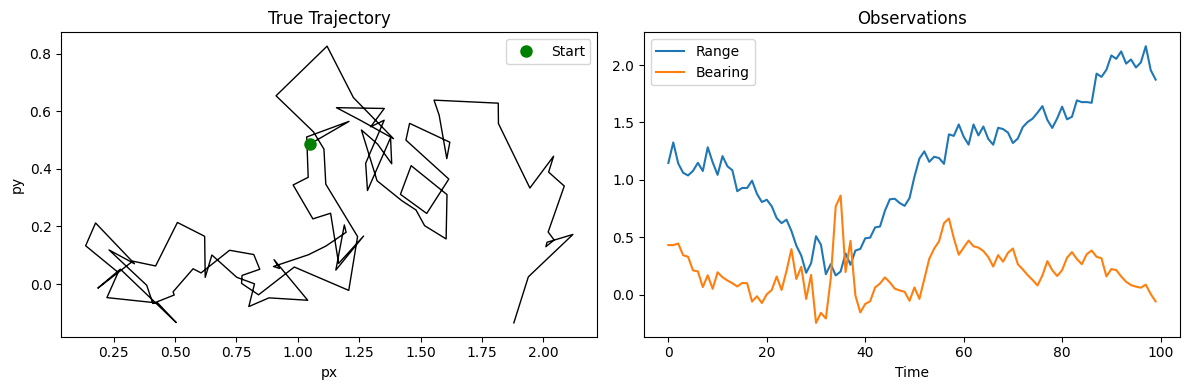

In [6]:
from scipy import stats as sp_stats

np.random.seed(42)

# Parameters (matching range_bearing.py defaults)
DT = 0.01
Q_DIAG = 0.01
NU = 2.0
S_R = 0.01
S_TH = 0.01
T_STEPS = 100

F_np = np.array([[1,0,DT,0],[0,1,0,DT],[0,0,1,0],[0,0,0,1]])
Q_np = np.diag(np.full(4, Q_DIAG))
Q_chol_np = np.linalg.cholesky(Q_np + 1e-6 * np.eye(4))

# Simulate
xs_true = np.zeros((T_STEPS, 4))
ys_true = np.zeros((T_STEPS, 2))

x = np.array([1.0, 0.5, 0.01, 0.01])  # m0

for t in range(T_STEPS):
    # Transition
    x = F_np @ x + Q_chol_np @ np.random.randn(4)
    xs_true[t] = x

    # Observation (range-bearing + Student-t noise)
    px, py = x[0], x[1]
    r = np.sqrt(px**2 + py**2 + 1e-12)
    th = np.arctan2(py, px)
    noise_r = sp_stats.t.rvs(df=NU, loc=0, scale=S_R)
    noise_th = sp_stats.t.rvs(df=NU, loc=0, scale=S_TH)
    ys_true[t] = [r + noise_r, (th + noise_th + np.pi) % (2*np.pi) - np.pi]

observations = tf.constant(ys_true, dtype=tf.float32)  # [T, 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(xs_true[:, 0], xs_true[:, 1], 'k-', linewidth=1)
axes[0].plot(xs_true[0, 0], xs_true[0, 1], 'go', markersize=8, label='Start')
axes[0].set_xlabel('px'); axes[0].set_ylabel('py')
axes[0].set_title('True Trajectory'); axes[0].legend()
axes[1].plot(ys_true[:, 0], label='Range')
axes[1].plot(ys_true[:, 1], label='Bearing')
axes[1].set_xlabel('Time'); axes[1].set_title('Observations')
axes[1].legend()
plt.tight_layout(); plt.show()

## Evaluation Function

In [7]:
def evaluate_config(epsilon, num_iters, observations, xs_true,
                    n_particles=200, batch_size=4, n_seeds=5):
    """Run PF for one (epsilon, K) config.
    Returns arrays of RMSE and time over seeds.
    """
    rmses, times = [], []

    for seed in range(n_seeds):
        tf.random.set_seed(seed * 1000 + 7)
        np.random.seed(seed * 1000 + 7)

        trans = RangeBearingTransition(dt=DT, q_diag=Q_DIAG)
        obs_m = RangeBearingObservation(nu=NU, s_r=S_R, s_th=S_TH)
        resampler = SinkhornResampler(epsilon=epsilon, num_iters=num_iters)
        dpf = DifferentiableParticleFilter(
            trans, obs_m, resampler, ess_threshold=0.5)

        t0 = time.time()
        all_p, all_lw, _ = dpf.filter(
            observations, batch_size=batch_size, n_particles=n_particles)
        elapsed = time.time() - t0

        # Position RMSE: compare weighted mean [px, py] vs truth
        sq_errs = []
        for t in range(len(all_p)):
            w = tf.exp(all_lw[t])                          # [B, N]
            pos_est = tf.reduce_sum(
                w[:, :, None] * all_p[t][..., :2], axis=1) # [B, 2]
            pos_mean = tf.reduce_mean(pos_est, axis=0)     # [2]
            sq_errs.append(
                tf.reduce_sum((pos_mean - xs_true[t, :2])**2).numpy())

        rmses.append(np.sqrt(np.mean(sq_errs)))
        times.append(elapsed)

    return np.array(rmses), np.array(times)

print("evaluate_config() defined.")

evaluate_config() defined.


## Grid Sweep

In [8]:
# ====== EXPERIMENT CONFIGURATION ======
EPSILONS    = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
ITERS_LIST  = [5,10,20,50,100]
N_PARTICLES = 100
BATCH_SIZE  = 10
N_SEEDS     = 20
# ======================================

results = {}
total = len(EPSILONS) * len(ITERS_LIST)
count = 0

print(f"Running {total} configs x {N_SEEDS} seeds ...")
print(f"{'eps':>8} {'K':>5} | {'RMSE mean':>10} {'RMSE std':>10} {'Time (s)':>10}")
print("-" * 50)

for eps in EPSILONS:
    for K in ITERS_LIST:
        count += 1
        rmses, times = evaluate_config(
            eps, K, observations, xs_true,
            N_PARTICLES, BATCH_SIZE, N_SEEDS)
        results[(eps, K)] = (rmses, times)

        print(f"{eps:8.3f} {K:5d} | "
              f"{rmses.mean():10.4f} {rmses.std():10.4f} "
              f"{times.mean():10.2f}  [{count}/{total}]")

print("\nDone.")

Running 30 configs x 5 seeds ...
     eps     K |  RMSE mean   RMSE std   Time (s)
--------------------------------------------------
   0.010     5 |     0.0391     0.0006       8.58  [1/30]
   0.010    10 |     0.0389     0.0015       6.82  [2/30]
   0.010    20 |     0.0401     0.0014       9.71  [3/30]
   0.010    50 |     0.0398     0.0020      17.26  [4/30]
   0.010   100 |     0.0385     0.0025      30.20  [5/30]
   0.050     5 |     0.0407     0.0015       5.41  [6/30]
   0.050    10 |     0.0412     0.0017       6.79  [7/30]
   0.050    20 |     0.0411     0.0015       9.39  [8/30]
   0.050    50 |     0.0410     0.0014      17.23  [9/30]
   0.050   100 |     0.0409     0.0014      30.01  [10/30]
   0.100     5 |     0.0416     0.0014       5.34  [11/30]
   0.100    10 |     0.0418     0.0014       6.70  [12/30]
   0.100    20 |     0.0418     0.0014       9.40  [13/30]
   0.100    50 |     0.0418     0.0014      17.07  [14/30]
   0.100   100 |     0.0418     0.0014      30.06

## Heatmaps: Mean RMSE and Mean Time

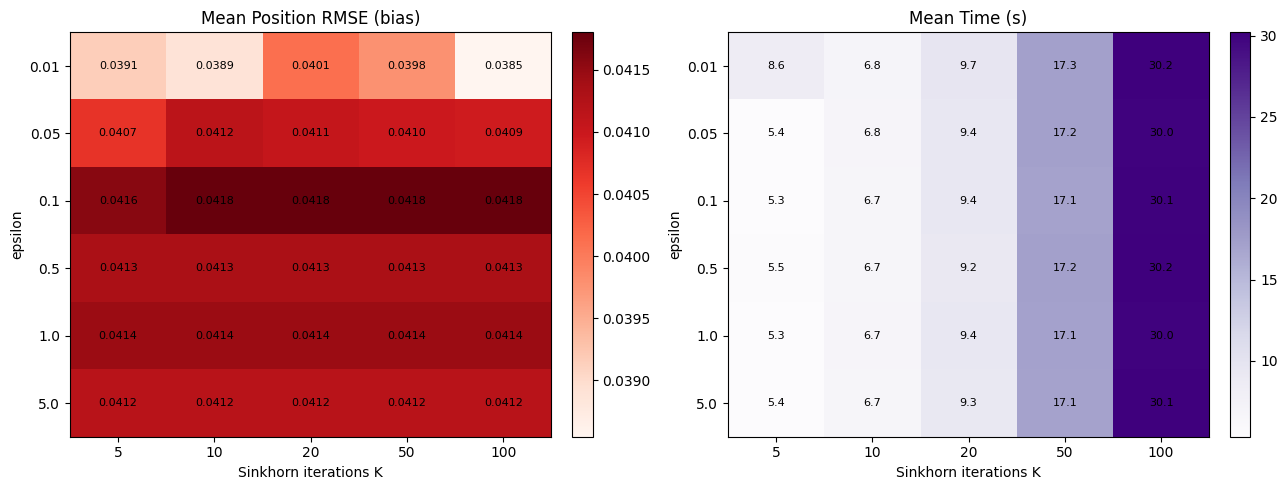

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, (label, extract, cmap, fmt) in zip(axes, [
    ('Mean Position RMSE (bias)',  lambda r: r[0].mean(), 'Reds',    '.4f'),
    ('Mean Time (s)',              lambda r: r[1].mean(), 'Purples', '.1f'),
]):
    mat = np.array([[extract(results[(eps, K)])
                     for K in ITERS_LIST] for eps in EPSILONS])
    im = ax.imshow(mat, aspect='auto', cmap=cmap)
    ax.set_xticks(range(len(ITERS_LIST)))
    ax.set_xticklabels(ITERS_LIST)
    ax.set_yticks(range(len(EPSILONS)))
    ax.set_yticklabels(EPSILONS)
    ax.set_xlabel('Sinkhorn iterations K')
    ax.set_ylabel('epsilon')
    ax.set_title(label)
    for i in range(len(EPSILONS)):
        for j in range(len(ITERS_LIST)):
            ax.text(j, i, f'{mat[i,j]:{fmt}}',
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## RMSE (mean ± std) vs K

Central plot: **bias** (mean) and **variance** (error bars) together.

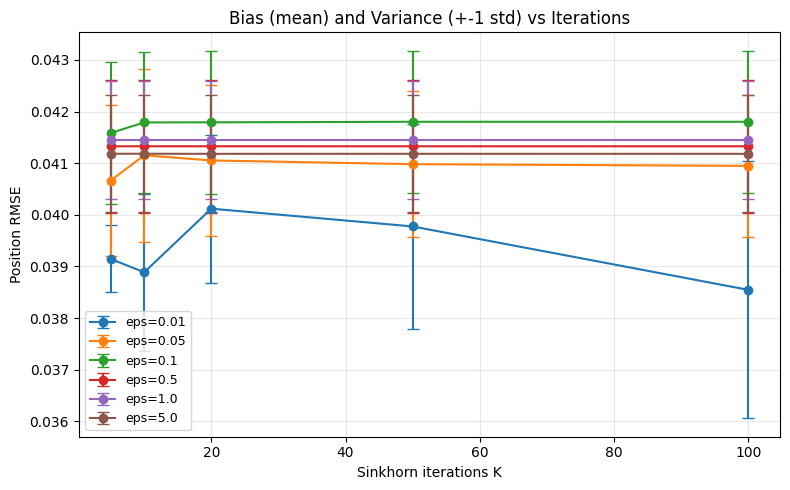

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

for eps in EPSILONS:
    means = [results[(eps, K)][0].mean() for K in ITERS_LIST]
    stds  = [results[(eps, K)][0].std()  for K in ITERS_LIST]
    ax.errorbar(ITERS_LIST, means, yerr=stds,
                fmt='o-', label=f'eps={eps}', capsize=4)

ax.set_xlabel('Sinkhorn iterations K')
ax.set_ylabel('Position RMSE')
ax.set_title('Bias (mean) and Variance (+-1 std) vs Iterations')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Pareto Front: RMSE vs Time

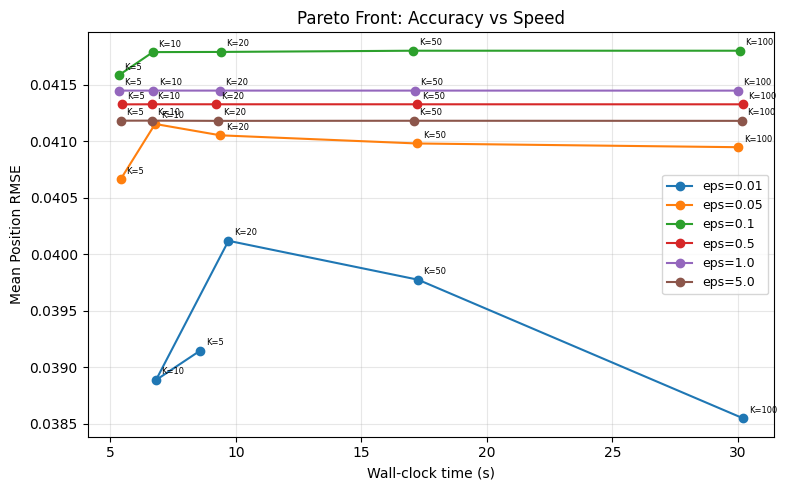

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

for eps in EPSILONS:
    t_vals = [results[(eps, K)][1].mean() for K in ITERS_LIST]
    r_vals = [results[(eps, K)][0].mean() for K in ITERS_LIST]
    ax.plot(t_vals, r_vals, 'o-', label=f'eps={eps}', markersize=6)
    for t, r, K in zip(t_vals, r_vals, ITERS_LIST):
        ax.annotate(f'K={K}', (t, r), fontsize=6,
                    textcoords='offset points', xytext=(4, 4))

ax.set_xlabel('Wall-clock time (s)')
ax.set_ylabel('Mean Position RMSE')
ax.set_title('Pareto Front: Accuracy vs Speed')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()